In [1]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import scipy.linalg as lng
import matplotlib
from sklearn.cluster import KMeans
import operator
%matplotlib inline
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
import mord
from sklearn.ensemble import RandomForestRegressor

#from sklearn.tree import export_graphviz
#import pydot
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'


In [2]:
def center(X):
    """ Center the columns (variables) of a data matrix to zero mean.
        
        X, MU = center(X) centers the observations of a data matrix such that each variable
        (column) has zero mean and also returns a vector MU of mean values for each variable.
     """ 
    n = X.shape[0]
    mu = np.mean(X,0)
    #X = X - np.ones((n,1)) * mu
    X = X - mu
    
    return X, mu

In [3]:
def normalize(X):
    """Normalize the columns (variables) of a data matrix to unit Euclidean length.
    X, MU, D = normalize(X)
    i) centers and scales the observations of a data matrix such
    that each variable (column) has unit Euclidean length. For a normalized matrix X,
    X'*X is equivalent to the correlation matrix of X.
    ii) returns a vector MU of mean values for each variable.
    iii) returns a vector D containing the Euclidean lengths for each original variable.
    
    """

    n = np.size(X, 0)
    X, mu = center(X)
    d = np.linalg.norm(X, ord = 2, axis = 0)
    d[np.where(d==0)] = 1
    X = np.divide(X, np.ones((n,1)) * d)
    return X, mu, d

In [116]:
data = pd.read_excel(r'M:\Documents\Courses\Credits\2019_04_August\Computational Data Analysis\Project\Data\Subject_Block_Session_Trial.xlsx')

data.dropna(subset=['ScoreDifficultyNew'], inplace=True, axis=0) # drop only nan in ScoreDifficultyNew
Y1_wNanInData = np.array(data.ScoreDifficultyNew.tolist())


data_woNa = data.dropna(inplace=False, axis=0) # drop nan values in all data
Y1 = data_woNa.ScoreDifficultyNew.tolist() # Y corresponding to data

#Y = [int(item) for item in Y]

#X = data.drop(['ScoreDifficultyNew'], axis = 1)

# drop some variables that are higher correlated to some other variables
data_new = data_woNa.drop(['PupilSizeAbsolute_writingMedian', 'BlinkCount', 'PupilSizeRelative_writingMedian', 'Subject', 'EffectiveTime'], axis=1)


# convert some data to categorical first
cols_categorical = ['SubjectID', 'BlockID', 'TypingTechniqueID', 'Session', 'Trial', 'ScoreDifficultyNew']
for cols in cols_categorical:
    data_new[cols] = data_new[cols].astype('category')

X = data_new.drop(['ScoreDifficultyNew', 'SubjectID', 'Block', 'BlockID', 'TypingTechnique', 'TypingTechniqueID', 'Session', 'SessionDifficulty', 'Trial'], \
             axis = 1)
#X.drop(['ScoreDifficultyNew'], axis=1, inplace=True)

X_norm, mu, d = normalize(X)

X_exptDesign = data_new.drop(['Block', 'TypingTechnique', 'SessionDifficulty',
       'TotalTime', 'ScoreDifficultyNew',
       'TypingSpeed', 'ErrorRate', 'PupilSizeAbsolute_writingMean',
       #'PupilSizeAbsolute_writingMedian',
       'PupilSizeAbsoluteDifference_writingStartingEnding_300ms',
       'PupilSizeRelative_writingMean', #'PupilSizeRelative_writingMedian',
       'PupilSizeRelative_writingStart300', 'LHIPA_writing20s', #'BlinkCount',
       'BlinkFrequency', 'BlinkDurationTotal', 'BlinkDurationAverage'], axis=1)

X_norm_all = pd.concat([X_exptDesign, X_norm], axis=1)


In [117]:
# create X with missing data
data_wNa = data.drop(['PupilSizeAbsolute_writingMedian', 'BlinkCount', 'PupilSizeRelative_writingMedian', 'Subject', 'EffectiveTime'], inplace=False, axis=1)

# convert some data to categorical first
cols_categorical = ['SubjectID', 'BlockID', 'TypingTechniqueID', 'Session', 'Trial', 'ScoreDifficultyNew']
for cols in cols_categorical:
    data_wNa[cols] = data_wNa[cols].astype('category')

X_wNa = data_wNa.drop(['ScoreDifficultyNew', 'SubjectID', 'Block', 'BlockID', 'TypingTechnique', 'TypingTechniqueID', 'Session', 'SessionDifficulty', 'Trial'], \
             axis = 1)
#X.drop(['ScoreDifficultyNew'], axis=1, inplace=True)

X_wNa_norm, mu, d = normalize(X_wNa)

X_wNa_exptDesign = data_wNa.drop(['Block', 'TypingTechnique', 'SessionDifficulty',
       'TotalTime', 'ScoreDifficultyNew',
       'TypingSpeed', 'ErrorRate', 'PupilSizeAbsolute_writingMean',
       #'PupilSizeAbsolute_writingMedian',
       'PupilSizeAbsoluteDifference_writingStartingEnding_300ms',
       'PupilSizeRelative_writingMean', #'PupilSizeRelative_writingMedian',
       'PupilSizeRelative_writingStart300', 'LHIPA_writing20s', #'BlinkCount',
       'BlinkFrequency', 'BlinkDurationTotal', 'BlinkDurationAverage'], axis=1)

X_wNa_norm_all = pd.concat([X_wNa_exptDesign, X_wNa_norm], axis=1)



In [119]:
from sklearn import preprocessing, metrics

le = preprocessing.LabelEncoder()
le.fit(Y1)
le.classes_
Y = le.transform(Y1)


le = preprocessing.LabelEncoder()
le.fit(Y1_wNanInData)
le.classes_
Y_wNanInData = le.transform(Y1_wNanInData)

# Unsupervised Learning

## K-means clustering

In [ ]:
def plotting(X, kmeans, y_pred, ax):
    ax[0].clear()
    ax[1].clear()
    
    ax[0].scatter(X.BlinkCount, X.ErrorRate, c = y_pred[:,0], marker= ".")
    ax[1].scatter(X.BlinkCount, X.ErrorRate, c = y_pred[:,1], marker= ".")
    
    ax[0].set_title("Last iteration")
    ax[1].set_title("Current iteration")

In [ ]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_norm)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()
    

In [ ]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 7, init = 'k-means++', random_state = 42)
y_pred = kmeans.fit_predict(X_norm)

plt.figure(figsize=(15,10))
x_variable = 'BlinkDurationAverage'
y_variable = 'BlinkFrequency'


plt.scatter(X_norm[x_variable], X_norm[y_variable], c=y_pred, marker='.', s=200)
plt.xlabel(x_variable)
plt.ylabel(y_variable)

cbar = plt.colorbar()
#plt.savefig(r'M:\Documents\Courses\Credits\2019_04_August\Computational Data Analysis\Project\Analysis\perceivedDifficulty\kmeans' + '\\'+ y_variable+'_'+x_variable+'.png')

## PCA

In [25]:
n, p = np.shape(X_norm)
u, d, v = np.linalg.svd(X_norm)

# Plot the two components and see if the perceived difficulty levels are differentiated
L = v # the loading
k = len(d)
d = d[0:k]
u = u[:, :k]
v = v[:k, :] # Matrix that is returned from svd is ordered differently, therefor different slicing

S = np.matmul(u, np.diag(d)) # The scores


(0, 105)

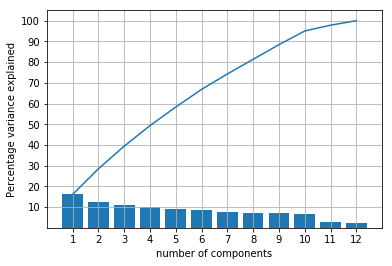

In [26]:
d_varianceExplained = list()
# Plot the variance explained by n components:

plt.figure()
plt.bar(range(1, len(d)+1), (d/sum(d))*100)

for i in range(1, len(d)+1):
    #print(len(d[0:i]), (sum(d[0:i])/sum(d))*100)
    d_varianceExplained.append((sum(d[0:i])/sum(d))*100)

plt.grid(b=True)
#d_varianceExplained = (d[0]/sum(d))*100
plt.plot(range(1, len(d)+1), d_varianceExplained)
plt.xlabel('number of components')
plt.ylabel('Percentage variance explained')
plt.xticks(range(1,len(d)+1))
plt.yticks(range(10,110,10))
plt.ylim([0,105])

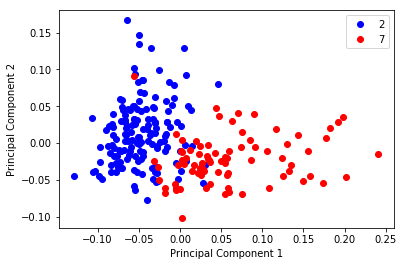

In [27]:

# for perceived score of 1, plot pc2 vs pc1:
#colorList = ['b', 'r', 'y', 'c', 'm', 'pink', 'g']

indices = Y==2
plt.figure()
plt.plot(S[indices, 0], S[indices, 1], 'ob', label=2)

indices = Y==7
plt.plot(S[indices, 0], S[indices, 1], 'or', label=7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

#for i in range(1,8):
#    indices = Y==i
#    plt.plot(S[indices, 1], S[indices,0], 'o', markerfacecolor=colorList[i-1], markeredgecolor=colorList[i-1], label=i)
plt.legend()


Text(0.5,1,'Scree plot')

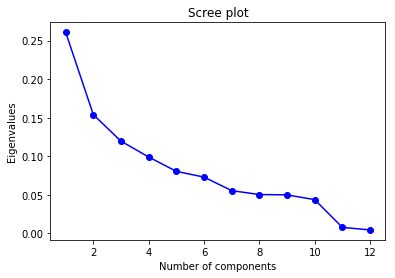

In [28]:
# Scree plot
sigma2 = d ** 2 / sum(d**2)
plt.figure()
plt.plot(range(1,len(d)+1), sigma2, '-ob')
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')
plt.title('Scree plot')

Var1 : TotalTime
Var2 : EffectiveTime
Var3 : TypingSpeed
Var4 : ErrorRate
Var5 : PupilSizeAbsolute_writingMean
Var6 : PupilSizeAbsoluteDifference_writingStartingEnding_300ms
Var7 : PupilSizeRelative_writingMean
Var8 : PupilSizeRelative_writingStart300
Var9 : LHIPA_writing20s
Var10 : BlinkFrequency
Var11 : BlinkDurationTotal
Var12 : BlinkDurationAverage


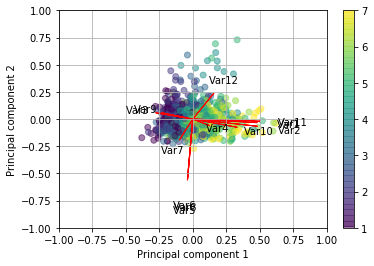

In [29]:
# Biplot and factor loadings
xs = S[:,0]
ys = S[:,1]
coeff = np.transpose(v[0:2,:])
n = coeff.shape[0]

scalex = 1.0/(xs.max() - xs.min())
scaley = 1.0/(ys.max() - ys.min())
plt.figure()
plt.scatter(xs * scalex,ys * scaley, c = Y, alpha=0.5)
plt.colorbar()

for i in range(n):
    
    label_ = 'Var'+str(i+1)+' : '+X_norm.columns[i]
    print(label_)
    plt.arrow(0, 0, coeff[i,0], coeff[i,1], color = 'r', alpha = 1)
    plt.text(coeff[i,0]*1.5, coeff[i,1]*1.5, "Var"+str(i+1), color = 'black', ha = 'center', va = 'center')
    
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.grid()


# Hierarchical clustering 

In [ ]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(X_norm, method='ward'), p=10, labels=Y)

In [ ]:
d_group = "ward"
N_leafs = 7

Z = linkage(X_norm, d_group, metric='euclidean')
labelList = range(1,8)

plt.figure()
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
den = dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=8.,
    truncate_mode='lastp',
    labels=Y,
    p = 50,
)
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

model = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')
model.fit(X_norm)
labels = model.labels_

plt.figure()
plt.scatter(X_norm['TotalTime_writing'], X_norm['PupilSizeRelative_writingMedian'], c=labels, cmap='rainbow')
plt.xlabel('TotalTime_writing'), plt.ylabel('PupilSizeRelative_writingMedian')
cbar = plt.colorbar()

plt.figure()
plt.scatter(X_norm['BlinkCount'], X_norm['TotalTime_writing'], c=labels, cmap='rainbow')
plt.xlabel('BlinkCount'), plt.ylabel('TotalTime_writing')
cbar = plt.colorbar()

In [ ]:
#dataPath = r"M:\Documents\Courses\Credits\2019_04_August\Computational Data Analysis\Module10\Solutions 10\Data"
#X = np.loadtxt(dataPath + '\\' + "zipdata.csv", delimiter = ",")

n, p = np.shape(X)
d_group = "ward"
N_leafs = 100

Z = linkage(X_norm, d_group)

plt.figure()
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
den = dendrogram(Z, leaf_rotation=90., leaf_font_size=8., truncate_mode='lastp', p = N_leafs,labels=Y)
plt.show()

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
 
# Data set
url = 'https://python-graph-gallery.com/wp-content/uploads/mtcars.csv'
df = pd.read_csv(url)
df = df.set_index('model')
del df.index.name
 
# Calculate the distance between each sample
Z = linkage(df, 'ward')
 
# Make the dendro
dendrogram(Z, labels=df.index, leaf_rotation=0, orientation="left", color_threshold=240, above_threshold_color='grey')

"""
# Create a color palette with 3 color for the 3 cyl possibilities
my_palette = plt.cm.get_cmap("Accent", 3)
 
# transforme the 'cyl' column in a categorical variable. It will allow to put one color on each level.
df['cyl']=pd.Categorical(df['cyl'])
my_color=df['cyl'].cat.codes
 
# Apply the right color to each label
ax = plt.gca()
xlbls = ax.get_ymajorticklabels()
num=-1
for lbl in xlbls:
    num+=1
    val=my_color[num]
    lbl.set_color(my_palette(val))

"""

## Features chosen on data based from above

In [95]:
X_norm_allReduced = X_norm_all.drop(['PupilSizeAbsolute_writingMean', \
'PupilSizeAbsoluteDifference_writingStartingEnding_300ms', 'PupilSizeRelative_writingMean', 'LHIPA_writing20s', \
'BlinkDurationAverage'], axis=1)

X_normReduced = X_norm.drop(['PupilSizeAbsolute_writingMean', \
'PupilSizeAbsoluteDifference_writingStartingEnding_300ms', 'PupilSizeRelative_writingMean', 'LHIPA_writing20s', \
'BlinkDurationAverage'], axis=1)

In [93]:
X_norm_allReduced.head()

,SubjectID,BlockID,TypingTechniqueID,Session,Trial,TotalTime,TypingSpeed,ErrorRate,PupilSizeRelative_writingStart300,BlinkFrequency,BlinkDurationTotal
0,1.0,1.0,1.0,1.0,0.0,-0.016127,-0.006768,-0.029719,-0.056420,0.068978,0.022400
1,1.0,1.0,1.0,1.0,1.0,-0.024759,-0.015421,-0.029719,0.031970,0.046282,0.001233
2,1.0,1.0,1.0,1.0,2.0,-0.037566,-0.007165,-0.009149,-0.006215,0.023133,-0.019565
3,1.0,1.0,1.0,1.0,3.0,-0.016004,-0.004969,-0.021707,0.010820,0.048643,0.012972
4,1.0,1.0,1.0,1.0,4.0,-0.036926,0.012007,-0.029719,-0.023880,0.019890,-0.021968
